# ROI Detection on Thickness Maps

This notebook experiments with different methods for creating regions of interest (ROI) on thickness maps based on B-scan level detections.

**Methods to explore:**
1. Line Thickening (morphological dilation)
2. Convex Hull (edge connection)
3. Bounding Rectangle
4. Gaussian Smoothing

In [1]:
# Import required libraries
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import cv2
from scipy.ndimage import gaussian_filter
from scipy.spatial import ConvexHull

## 1. Data Loading

In [2]:
# Paths
data_path = '/home/suraj/Data/Nemours/Nemours_Jing_0929.h5'
detection_path = '/home/suraj/Git/RCNN-OCT/nemours_inference/full_dataset_inference.pkl'


In [3]:
# Load HDF5 annotations data
print("Loading HDF5 annotations data...")
with h5py.File(data_path, 'r') as f:
    print("\nHDF5 Keys:", list(f.keys()))
    
    # Load images and names
    images = f['images'][:]
    names = f['names'][:]
    bscan_indices = f['bscan_indices'][:]
    
    # Decode names if they're bytes
    if isinstance(names[0], bytes):
        names = [name.decode('utf-8') for name in names]
    
    # Load layer annotations (ILM and BM)
    ilm_coords = f['layers/ILM'][:]
    bm_coords = f['layers/BM'][:]
    
    print(f"\nHDF5 Dataset shapes:")
    print(f"  Images: {images.shape}")
    print(f"  Names: {len(names)}")
    print(f"  B-scan indices: {bscan_indices.shape}")
    print(f"  ILM coords: {ilm_coords.shape}")
    print(f"  BM coords: {bm_coords.shape}")

# Get unique volume names
unique_volumes = []
seen_volumes = set()
for name in names:
    if name not in seen_volumes:
        unique_volumes.append(name)
        seen_volumes.add(name)
        if len(unique_volumes) >= 10:
            break

print(f"\nFirst 10 unique volume names from HDF5:")
for i, vol_name in enumerate(unique_volumes):
    print(f"  {i+1}: {vol_name}")

Loading HDF5 annotations data...

HDF5 Keys: ['bscan_indices', 'images', 'layers', 'names']

HDF5 Dataset shapes:
  Images: (2540, 496, 768)
  Names: 2540
  B-scan indices: (2540,)
  ILM coords: (2540, 768)
  BM coords: (2540, 768)

First 10 unique volume names from HDF5:
  1: 256_L_1_1.e2e
  2: 256_L_1_3.e2e
  3: 256_L_1_4.e2e
  4: 142_R_3.e2e
  5: 62_R_6.e2e
  6: 242_L_1.e2e
  7: 25_R_3.e2e
  8: 247_L_1_1.e2e
  9: 247_L_1_2.e2e
  10: 62_L_6.e2e


In [4]:
# Load inference detections
print("\nLoading inference detections...")
with open(detection_path, 'rb') as f:
    detection_data = pickle.load(f)

print(f"\nDetection data type: {type(detection_data)}")
print(f"Number of volumes in detection data: {len(detection_data)}")

print(f"\nFirst 10 volume IDs from detection data:")
for i, vol_id in enumerate(list(detection_data.keys())[:10]):
    num_bscans = len(detection_data[vol_id])
    print(f"  {i}: {vol_id} (B-scans: {num_bscans})")
    
# Show sample detection structure
sample_vol = list(detection_data.keys())[0]
sample_bscan = detection_data[sample_vol][0]
print(f"\nSample detection keys: {sample_bscan.keys()}")


Loading inference detections...

Detection data type: <class 'dict'>
Number of volumes in detection data: 104

First 10 volume IDs from detection data:
  0: 256_L_1_1 (B-scans: 28)
  1: 256_L_1_3 (B-scans: 5)
  2: 256_L_1_4 (B-scans: 5)
  3: 142_R_3 (B-scans: 31)
  4: 62_R_6 (B-scans: 31)
  5: 242_L_1 (B-scans: 31)
  6: 25_R_3 (B-scans: 31)
  7: 247_L_1_1 (B-scans: 31)
  8: 247_L_1_2 (B-scans: 5)
  9: 62_L_6 (B-scans: 31)

Sample detection keys: dict_keys(['image', 'pred_boxes', 'pred_scores', 'pred_labels', 'bscan_idx', 'global_idx', 'volume_id'])


In [5]:
# Create mappings
hdf5_mapping = {}
for idx, (name, bscan_idx) in enumerate(zip(names, bscan_indices)):
    vol_id = name.replace('.e2e', '')
    key = f"{vol_id}_{bscan_idx:03d}"
    hdf5_mapping[key] = {
        'global_idx': idx,
        'volume_id': vol_id,
        'bscan_idx': bscan_idx,
        'original_name': name
    }

detection_mapping = {}
for vol_id, bscans in detection_data.items():
    for bscan_data in bscans:
        bscan_idx = bscan_data['bscan_idx']
        key = f"{vol_id}_{bscan_idx:03d}"
        detection_mapping[key] = {
            'volume_id': vol_id,
            'bscan_idx': bscan_idx,
            'pred_boxes': bscan_data['pred_boxes'],
            'pred_labels': bscan_data['pred_labels'],
            'pred_scores': bscan_data['pred_scores']
        }

# Find matching volumes
matching_volumes = defaultdict(list)
matching_keys = set(hdf5_mapping.keys()) & set(detection_mapping.keys())
for key in matching_keys:
    vol_id = hdf5_mapping[key]['volume_id']
    bscan_idx = hdf5_mapping[key]['bscan_idx']
    matching_volumes[vol_id].append(bscan_idx)

print(f"Found {len(matching_volumes)} volumes with matching data")

Found 104 volumes with matching data


## 2. Select Sample Volume

Choose a volume with detections for experimentation.

In [6]:
# Select a volume with good number of B-scans and detections
sample_volume = '185_R_3'  # This has 31 B-scans

if sample_volume not in matching_volumes:
    # Pick first volume with 31 B-scans
    for vol_id, bscan_list in matching_volumes.items():
        if len(bscan_list) == 31:
            sample_volume = vol_id
            break

bscan_list = sorted(matching_volumes[sample_volume])
print(f"Selected volume: {sample_volume}")
print(f"Number of B-scans: {len(bscan_list)}")
print(f"B-scan indices: {min(bscan_list)}-{max(bscan_list)}")

Selected volume: 185_R_3
Number of B-scans: 31
B-scan indices: 0-30


## 3. Generate Thickness Map

In [7]:
# Compute thickness map for selected volume
thickness_map = []
detection_info = []

for bscan_idx in bscan_list:
    key = f"{sample_volume}_{bscan_idx:03d}"
    
    # Get layer data
    hdf5_data = hdf5_mapping[key]
    global_idx = hdf5_data['global_idx']
    ilm = ilm_coords[global_idx]
    bm = bm_coords[global_idx]
    
    # Compute thickness (BM - ILM)
    thickness = bm - ilm
    thickness_map.append(thickness)
    
    # Get detection data
    det_data = detection_mapping[key]
    detection_info.append({
        'bscan_idx': bscan_idx,
        'boxes': det_data['pred_boxes'],
        'labels': det_data['pred_labels'],
        'scores': det_data['pred_scores']
    })

thickness_map = np.array(thickness_map)
print(f"Thickness map shape: {thickness_map.shape}")
print(f"Thickness range: {np.nanmin(thickness_map):.1f} - {np.nanmax(thickness_map):.1f} pixels")

Thickness map shape: (31, 768)
Thickness range: 39.7 - 88.4 pixels


In [ ]:
# Visualize thickness map
plt.figure(figsize=(12, 6))
plt.imshow(thickness_map, cmap='jet', aspect='auto')
plt.colorbar(label='Thickness (pixels)')
plt.xlabel('A-scan Index')
plt.ylabel('B-scan Index')
plt.title(f'Thickness Map - {sample_volume}')
plt.tight_layout()
plt.show()

## 4. Project Detections onto Thickness Map

Create baseline projection showing detection centroids as single-pixel lines.

In [9]:
def project_detections(detection_info, thickness_map_shape, score_threshold=0.7):
    """
    Project B-scan detections onto thickness map coordinates.
    Returns binary masks for each class.
    """
    num_bscans, width = thickness_map_shape
    
    # Create masks for each class (1=fovea, 2=lesion)
    masks = {
        'fovea': np.zeros(thickness_map_shape, dtype=np.uint8),
        'lesion': np.zeros(thickness_map_shape, dtype=np.uint8)
    }
    
    # Store points for each class (for convex hull)
    points = {
        'fovea': [],
        'lesion': []
    }
    
    for i, det in enumerate(detection_info):
        boxes = det['boxes']
        labels = det['labels']
        scores = det['scores']
        
        for box, label, score in zip(boxes, labels, scores):
            if score < score_threshold:
                continue
                
            x1, y1, x2, y2 = box
            
            # Compute centroid
            cx = int((x1 + x2) / 2)
            
            # Ensure within bounds
            cx = np.clip(cx, 0, width - 1)
            
            # Map label to class name
            class_name = 'fovea' if label == 1 else 'lesion' if label == 2 else None
            
            if class_name:
                masks[class_name][i, cx] = 1
                points[class_name].append([i, cx])  # [row, col] format
    
    return masks, points

# Project detections
detection_masks, detection_points = project_detections(detection_info, thickness_map.shape)

print(f"Fovea detections: {np.sum(detection_masks['fovea'])} pixels")
print(f"Lesion detections: {np.sum(detection_masks['lesion'])} pixels")

Fovea detections: 7 pixels
Lesion detections: 27 pixels


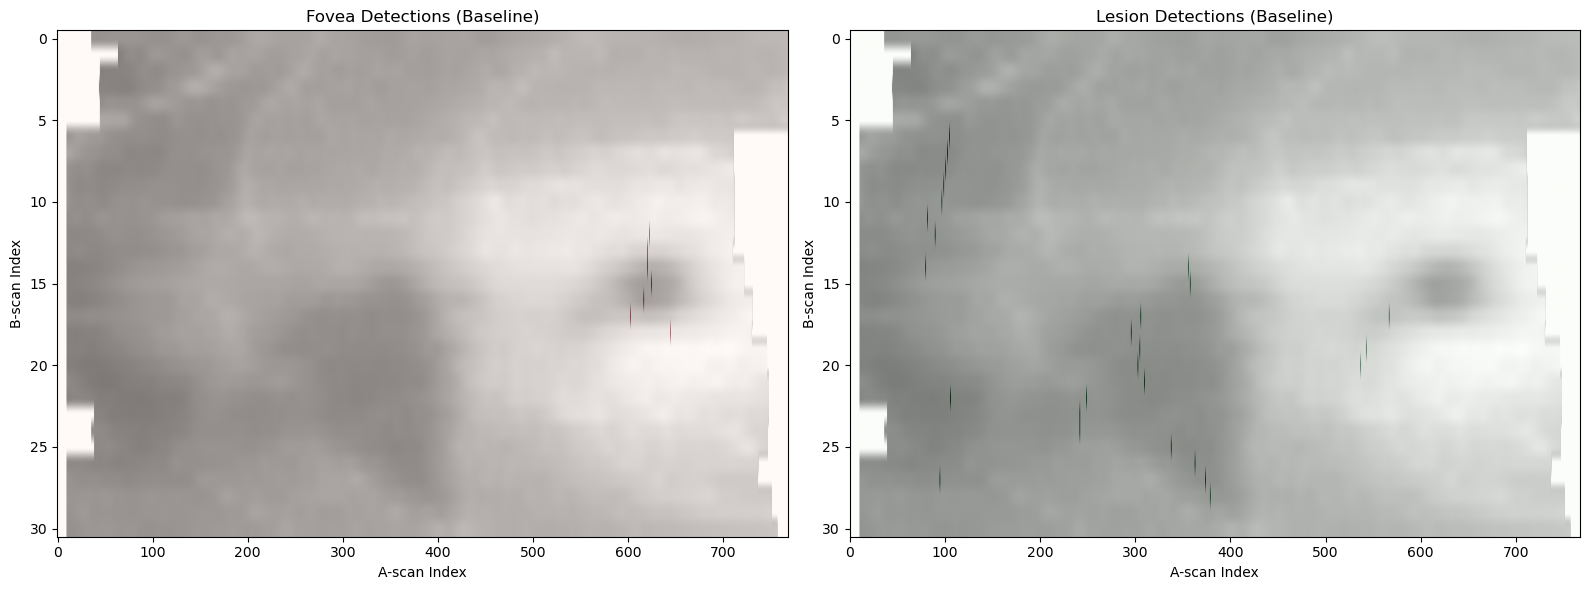

In [10]:
# Visualize baseline projection
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fovea
axes[0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0].imshow(detection_masks['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[0].set_title('Fovea Detections (Baseline)')
axes[0].set_xlabel('A-scan Index')
axes[0].set_ylabel('B-scan Index')

# Lesion
axes[1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1].imshow(detection_masks['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[1].set_title('Lesion Detections (Baseline)')
axes[1].set_xlabel('A-scan Index')
axes[1].set_ylabel('B-scan Index')

plt.tight_layout()
plt.show()

## 5. Method 1: Line Thickening

Apply morphological dilation with different kernel sizes.

In [ ]:
def thicken_lines(binary_mask, kernel_size):
    """
    Apply morphological dilation to thicken detection lines.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thickened = cv2.dilate(binary_mask, kernel, iterations=1)
    return thickened

# Test different kernel sizes
kernel_sizes = [3, 5, 7, 9, 11]
thickened_masks = {}

for k_size in kernel_sizes:
    thickened_masks[k_size] = {
        'fovea': thicken_lines(detection_masks['fovea'], k_size),
        'lesion': thicken_lines(detection_masks['lesion'], k_size)
    }

print("Generated thickened masks for kernel sizes:", kernel_sizes)

In [ ]:
# Visualize line thickening results - Fovea
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, k_size in enumerate(kernel_sizes):
    axes[idx].imshow(thickness_map, cmap='gray', aspect='auto')
    axes[idx].imshow(thickened_masks[k_size]['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
    axes[idx].set_title(f'Fovea - Kernel {k_size}x{k_size}')
    axes[idx].set_xlabel('A-scan Index')
    axes[idx].set_ylabel('B-scan Index')

# Hide last subplot if odd number
if len(kernel_sizes) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Visualize line thickening results - Lesion
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, k_size in enumerate(kernel_sizes):
    axes[idx].imshow(thickness_map, cmap='gray', aspect='auto')
    axes[idx].imshow(thickened_masks[k_size]['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
    axes[idx].set_title(f'Lesion - Kernel {k_size}x{k_size}')
    axes[idx].set_xlabel('A-scan Index')
    axes[idx].set_ylabel('B-scan Index')

if len(kernel_sizes) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 6. Method 2: Convex Hull

Connect outer edges of detection points to create polygonal ROI.

In [ ]:
def create_convex_hull_mask(points, map_shape):
    """
    Create filled convex hull mask from detection points.
    """
    mask = np.zeros(map_shape, dtype=np.uint8)
    
    if len(points) < 3:
        # Need at least 3 points for convex hull
        return mask
    
    points = np.array(points)
    
    try:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        
        # Convert to format for cv2.fillPoly: (x, y) format
        hull_points_cv = hull_points[:, [1, 0]]  # Swap to (col, row)
        hull_points_cv = hull_points_cv.astype(np.int32)
        
        cv2.fillPoly(mask, [hull_points_cv], 1)
    except:
        # If convex hull fails (e.g., collinear points), return empty mask
        pass
    
    return mask

# Create convex hull masks
convex_hull_masks = {
    'fovea': create_convex_hull_mask(detection_points['fovea'], thickness_map.shape),
    'lesion': create_convex_hull_mask(detection_points['lesion'], thickness_map.shape)
}

print(f"Fovea convex hull area: {np.sum(convex_hull_masks['fovea'])} pixels")
print(f"Lesion convex hull area: {np.sum(convex_hull_masks['lesion'])} pixels")

In [ ]:
# Visualize convex hull
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fovea
axes[0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0].imshow(convex_hull_masks['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[0].set_title('Fovea - Convex Hull ROI')
axes[0].set_xlabel('A-scan Index')
axes[0].set_ylabel('B-scan Index')

# Lesion
axes[1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1].imshow(convex_hull_masks['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[1].set_title('Lesion - Convex Hull ROI')
axes[1].set_xlabel('A-scan Index')
axes[1].set_ylabel('B-scan Index')

plt.tight_layout()
plt.show()

## 7. Method 3: Bounding Rectangle

Create rectangular ROI from min/max bounds of detection points.

In [ ]:
def create_bounding_rect_mask(points, map_shape):
    """
    Create rectangular ROI from point bounds.
    """
    mask = np.zeros(map_shape, dtype=np.uint8)
    
    if len(points) == 0:
        return mask
    
    points = np.array(points)
    
    # Find bounds
    min_row = int(np.min(points[:, 0]))
    max_row = int(np.max(points[:, 0]))
    min_col = int(np.min(points[:, 1]))
    max_col = int(np.max(points[:, 1]))
    
    # Fill rectangle
    mask[min_row:max_row+1, min_col:max_col+1] = 1
    
    return mask

# Create bounding rectangle masks
bounding_rect_masks = {
    'fovea': create_bounding_rect_mask(detection_points['fovea'], thickness_map.shape),
    'lesion': create_bounding_rect_mask(detection_points['lesion'], thickness_map.shape)
}

print(f"Fovea bounding rect area: {np.sum(bounding_rect_masks['fovea'])} pixels")
print(f"Lesion bounding rect area: {np.sum(bounding_rect_masks['lesion'])} pixels")

In [ ]:
# Visualize bounding rectangles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fovea
axes[0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0].imshow(bounding_rect_masks['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[0].set_title('Fovea - Bounding Rectangle ROI')
axes[0].set_xlabel('A-scan Index')
axes[0].set_ylabel('B-scan Index')

# Lesion
axes[1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1].imshow(bounding_rect_masks['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[1].set_title('Lesion - Bounding Rectangle ROI')
axes[1].set_xlabel('A-scan Index')
axes[1].set_ylabel('B-scan Index')

plt.tight_layout()
plt.show()

## 8. Method 4: Gaussian Smoothing

Apply Gaussian blur to create soft probability-like boundaries.

In [ ]:
def gaussian_smooth_mask(binary_mask, sigma, threshold=0.1):
    """
    Apply Gaussian smoothing to create soft ROI boundaries.
    """
    # Apply Gaussian filter
    smoothed = gaussian_filter(binary_mask.astype(float), sigma=sigma)
    
    # Normalize to [0, 1]
    if smoothed.max() > 0:
        smoothed = smoothed / smoothed.max()
    
    # Threshold to create binary mask
    binary = (smoothed > threshold).astype(np.uint8)
    
    return smoothed, binary

# Test different sigma values
sigma_values = [1.0, 2.0, 3.0, 5.0]
gaussian_masks = {}

for sigma in sigma_values:
    gaussian_masks[sigma] = {
        'fovea': gaussian_smooth_mask(detection_masks['fovea'], sigma),
        'lesion': gaussian_smooth_mask(detection_masks['lesion'], sigma)
    }

print("Generated Gaussian smoothed masks for sigma values:", sigma_values)

In [ ]:
# Visualize Gaussian smoothing - Fovea (probability maps)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sigma in enumerate(sigma_values):
    smoothed, binary = gaussian_masks[sigma]['fovea']
    
    axes[idx].imshow(thickness_map, cmap='gray', aspect='auto', alpha=0.5)
    im = axes[idx].imshow(smoothed, cmap='Reds', aspect='auto', alpha=0.7)
    axes[idx].set_title(f'Fovea - Gaussian σ={sigma} (Probability)')
    axes[idx].set_xlabel('A-scan Index')
    axes[idx].set_ylabel('B-scan Index')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
# Visualize Gaussian smoothing - Fovea (binary masks)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sigma in enumerate(sigma_values):
    smoothed, binary = gaussian_masks[sigma]['fovea']
    
    axes[idx].imshow(thickness_map, cmap='gray', aspect='auto')
    axes[idx].imshow(binary, cmap='Reds', alpha=0.5, aspect='auto')
    axes[idx].set_title(f'Fovea - Gaussian σ={sigma} (Binary)')
    axes[idx].set_xlabel('A-scan Index')
    axes[idx].set_ylabel('B-scan Index')

plt.tight_layout()
plt.show()

In [ ]:
# Visualize Gaussian smoothing - Lesion (probability maps)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sigma in enumerate(sigma_values):
    smoothed, binary = gaussian_masks[sigma]['lesion']
    
    axes[idx].imshow(thickness_map, cmap='gray', aspect='auto', alpha=0.5)
    im = axes[idx].imshow(smoothed, cmap='Greens', aspect='auto', alpha=0.7)
    axes[idx].set_title(f'Lesion - Gaussian σ={sigma} (Probability)')
    axes[idx].set_xlabel('A-scan Index')
    axes[idx].set_ylabel('B-scan Index')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

## 9. Comparison of Methods

Side-by-side comparison of all ROI creation methods.

In [ ]:
# Compare methods for Fovea
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Baseline
axes[0, 0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0, 0].imshow(detection_masks['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[0, 0].set_title('Baseline (Single Pixel)')
axes[0, 0].set_ylabel('B-scan Index')

# Line Thickening (kernel=7)
axes[0, 1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0, 1].imshow(thickened_masks[7]['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[0, 1].set_title('Line Thickening (7x7)')

# Convex Hull
axes[0, 2].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0, 2].imshow(convex_hull_masks['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[0, 2].set_title('Convex Hull')

# Bounding Rectangle
axes[1, 0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1, 0].imshow(bounding_rect_masks['fovea'], cmap='Reds', alpha=0.5, aspect='auto')
axes[1, 0].set_title('Bounding Rectangle')
axes[1, 0].set_xlabel('A-scan Index')
axes[1, 0].set_ylabel('B-scan Index')

# Gaussian (sigma=3)
smoothed, binary = gaussian_masks[3.0]['fovea']
axes[1, 1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1, 1].imshow(binary, cmap='Reds', alpha=0.5, aspect='auto')
axes[1, 1].set_title('Gaussian Smoothing (σ=3)')
axes[1, 1].set_xlabel('A-scan Index')

# Gaussian probability
axes[1, 2].imshow(thickness_map, cmap='gray', aspect='auto', alpha=0.5)
im = axes[1, 2].imshow(smoothed, cmap='Reds', aspect='auto', alpha=0.7)
axes[1, 2].set_title('Gaussian Probability (σ=3)')
axes[1, 2].set_xlabel('A-scan Index')
plt.colorbar(im, ax=axes[1, 2])

fig.suptitle('Fovea ROI Methods Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Compare methods for Lesion
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Baseline
axes[0, 0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0, 0].imshow(detection_masks['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[0, 0].set_title('Baseline (Single Pixel)')
axes[0, 0].set_ylabel('B-scan Index')

# Line Thickening (kernel=7)
axes[0, 1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0, 1].imshow(thickened_masks[7]['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[0, 1].set_title('Line Thickening (7x7)')

# Convex Hull
axes[0, 2].imshow(thickness_map, cmap='gray', aspect='auto')
axes[0, 2].imshow(convex_hull_masks['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[0, 2].set_title('Convex Hull')

# Bounding Rectangle
axes[1, 0].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1, 0].imshow(bounding_rect_masks['lesion'], cmap='Greens', alpha=0.5, aspect='auto')
axes[1, 0].set_title('Bounding Rectangle')
axes[1, 0].set_xlabel('A-scan Index')
axes[1, 0].set_ylabel('B-scan Index')

# Gaussian (sigma=3)
smoothed, binary = gaussian_masks[3.0]['lesion']
axes[1, 1].imshow(thickness_map, cmap='gray', aspect='auto')
axes[1, 1].imshow(binary, cmap='Greens', alpha=0.5, aspect='auto')
axes[1, 1].set_title('Gaussian Smoothing (σ=3)')
axes[1, 1].set_xlabel('A-scan Index')

# Gaussian probability
axes[1, 2].imshow(thickness_map, cmap='gray', aspect='auto', alpha=0.5)
im = axes[1, 2].imshow(smoothed, cmap='Greens', aspect='auto', alpha=0.7)
axes[1, 2].set_title('Gaussian Probability (σ=3)')
axes[1, 2].set_xlabel('A-scan Index')
plt.colorbar(im, ax=axes[1, 2])

fig.suptitle('Lesion ROI Methods Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Summary Statistics

In [ ]:
# Print area statistics for each method
print("=" * 60)
print("ROI AREA COMPARISON (in pixels)")
print("=" * 60)

print("\nFOVEA:")
print(f"  Baseline:              {np.sum(detection_masks['fovea']):5d} pixels")
print(f"  Line Thickening (7x7): {np.sum(thickened_masks[7]['fovea']):5d} pixels")
print(f"  Convex Hull:           {np.sum(convex_hull_masks['fovea']):5d} pixels")
print(f"  Bounding Rectangle:    {np.sum(bounding_rect_masks['fovea']):5d} pixels")
smoothed, binary = gaussian_masks[3.0]['fovea']
print(f"  Gaussian (σ=3):        {np.sum(binary):5d} pixels")

print("\nLESION:")
print(f"  Baseline:              {np.sum(detection_masks['lesion']):5d} pixels")
print(f"  Line Thickening (7x7): {np.sum(thickened_masks[7]['lesion']):5d} pixels")
print(f"  Convex Hull:           {np.sum(convex_hull_masks['lesion']):5d} pixels")
print(f"  Bounding Rectangle:    {np.sum(bounding_rect_masks['lesion']):5d} pixels")
smoothed, binary = gaussian_masks[3.0]['lesion']
print(f"  Gaussian (σ=3):        {np.sum(binary):5d} pixels")

print("\n" + "=" * 60)